In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy as sym
from scipy.integrate import quad
from scipy.optimize import minimize, root
from scipy.special import erf
from scipy.stats import (
    bootstrap, chi2, describe, 
    expon, norm, t as stud, uniform
)
from sympy import Symbol
from sympy.stats import density, Die, E, Normal, sample
sns.set_theme()

***
### __Свойства нормального распределения__

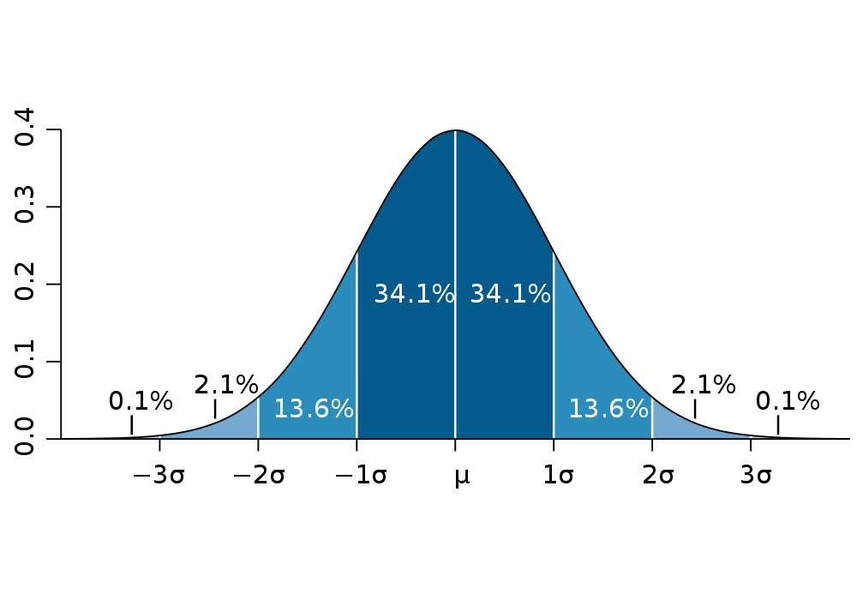

Плотность вероятности непрерывной с.в., имеющей нормальный закон распределения (закон Гаусса) с параметрами $a$ и $\sigma^2$:

$$\varphi_N(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-a)^2}{2\sigma^2}},$$

$$\text{E}(X) = a,\,\text{D}(X) = \sigma^2$$

Функция распределения с.в. $X$ через функцию Лапласа $\Phi(x)$:

$$\text{F}_N(x) = \frac{1}{2} + \frac{1}{2}\Phi\biggl(\frac{x-a}{\sigma}\biggr),$$

$$\Phi(x) = \frac{2}{\sqrt{2\pi}} \int_0^x e^{\frac{-t^2}{2}}\,dt = \frac{1}{\sqrt{2\pi}} \int_{-x}^x e^{\frac{-t^2}{2}}\,dt$$

Посмотрим, какая доля вероятностной массы нормального распределения заключена соответственно в интервалах $(-\sigma,\sigma)$, $(-2\sigma,2\sigma)$, $(-3\sigma,3\sigma)$.

__Способ 1__. Воспользуемся функцией распределения:

In [2]:
f = lambda x: norm.cdf(x) - norm.cdf(-x)
[f(sigma) for sigma in range(1, 4)]

[0.6826894921370859, 0.9544997361036416, 0.9973002039367398]

__Способ 2__.
$$\textbf{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}\,dt = \overbrace{\Phi(x\sqrt{2})}^{\text{Кремер, с.161}}$$

$$\text{F}(x) = \frac{1 + \textbf{erf}(x/\sqrt{2})}{2}$$

$$\text{F}(x) - \text{F}(-x) = \frac{1}{2} \biggl(\textbf{erf}\biggl(\frac{x}{\sqrt{2}}\biggr) - \textbf{erf}\biggl(-\frac{x}{\sqrt{2}}\biggr)\biggr)$$

см. [__Функция ошибок Гаусса__](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA)
<br> см. [__CDF and ERF relation__](https://stats.stackexchange.com/questions/187828/how-are-the-error-function-and-standard-normal-distribution-function-related)
<br>см. [__scipy.special.erf__](https://scipy.github.io/devdocs/reference/generated/scipy.special.erf.html#scipy-special-erf)
<br>см. [__The Gauss error function__](https://docs.sympy.org/latest/modules/functions/special.html?highlight=erf#sympy.functions.special.error_functions.erf)

In [3]:
g = lambda x: 1/2 * (erf(x / np.sqrt(2)) - erf(-x / np.sqrt(2)))
[g(x) for x in range(1, 4)]

[0.6826894921370859, 0.9544997361036416, 0.9973002039367398]

In [4]:
f = lambda x: 1/2 * (sym.erf(x / sym.sqrt(2)) - sym.erf(-x / sym.sqrt(2)))
[f(x).evalf() for x in range(1, 4)]

[0.682689492137086, 0.954499736103642, 0.997300203936740]

__Способ 3__. Проверим результат интегрированием плотности вероятности в тех же пределах:

In [5]:
[quad(norm.pdf, -sigma, sigma)[0] for sigma in range(1, 4)]

[0.682689492137086, 0.9544997361036417, 0.9973002039367399]

In [6]:
x = Symbol('x')
N = Normal('N', 0, 1)
pdf = density(N)(x)
pdf

sqrt(2)*exp(-x**2/2)/(2*sqrt(pi))

In [7]:
[sym.integrate(pdf, (x, -s, s)).evalf() for s in range(1, 4)]

[0.682689492137086, 0.954499736103642, 0.997300203936740]

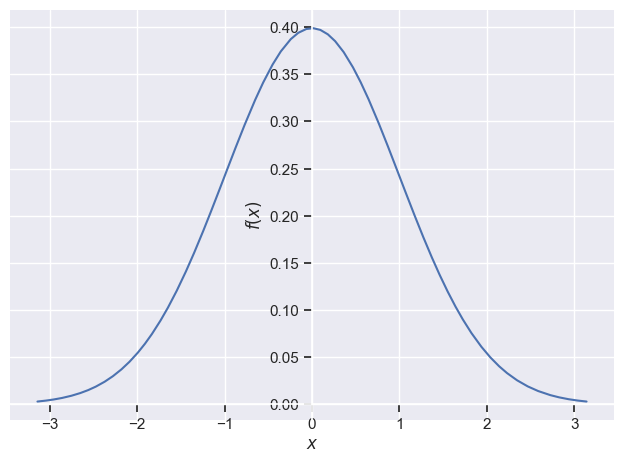

In [8]:
sym.plot(pdf, (x, -sym.pi, sym.pi))

Как видно, в ~$99.7\%$ случаях значение нормально распределенной случайной величины отклоняется от среднего не более, чем на $3\sigma$. Поэтому на практике хорошо работает __"правило трех сигм"__: _практически достоверно_, что значения нормально распределенной случайной величины заключены в интервале $(\mu-3\sigma,\mu+3\sigma)$.

Примерно $68\%$ значений из нормального распределения расположены не далее чем в одном стандартном отклонении от среднего - сосредоточены в интервале $(-\sigma,\sigma)$. А между какими значениями заключены центральные $50\%$?

Очевидно, что, поскольку нормальное распределение обладает осевой симметрией, центральные пятьдесят процентов заключены между его $25$-ым и $75$-ым квантилями:

In [9]:
left = norm.ppf(.25)
right = norm.ppf(.75)
left, right

(-0.6744897501960817, 0.6744897501960817)

In [10]:
# проверка №1
norm.cdf(right) - norm.cdf(left)

0.5

In [11]:
# проверка №2
g = lambda x: norm.cdf(x) - norm.cdf(-x) - 0.5
result = root(g, x0=.6)  # x0, initial guess, стартовая точка спуска
result

 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00]
       x: [ 6.745e-01]
    nfev: 7
    fjac: [[-1.000e+00]]
       r: [-6.356e-01]
     qtf: [ 2.063e-13]

In [12]:
result.x.item()

0.6744897501960816

***
### __Закон больших чисел__

Пусть $\xi_1,\xi_2,...,\xi_n,...$ - бесконечная последовательность независимых одинаково распределенных случайных величин, имеющих конечное матожидание $\mu$. Обозначим среднее арифметическое первых $n$ случайных величин $\xi_1,\xi_2,...,\xi_n$ так:

$$\overline{\xi}_n = \frac{1}{n} \sum_{i=1}^{n} \xi_i.$$

Тогда для любого $\varepsilon > 0$:

$$\lim_{n \to +\infty} P(|\overline{\xi}_n - \mu| < \varepsilon) = 1.$$

В таких случаях говорят, что ряд случайных величин ${\overline{\xi}_n}$ сходится к $\mu$ по вероятности.
<br>ЗБЧ показывает, что для любого положительного $\varepsilon$ вероятность того, что $\overline{\xi}_n​$ отклоняется от $\mu$ больше, чем на $\varepsilon$ стремится к $0$ при $n \to +\infty$.

__Пример__.

In [13]:
D = Die('D')
sizes = np.geomspace(10, 1e6, num=6, dtype=int)  # 10**np.arange(1, 7)
sizes

array([     10,     100,    1000,   10000,  100000, 1000000])

In [14]:
f = lambda size: np.mean(sample(D, size=size))
means = np.vectorize(f)(sizes)
means

array([3.6     , 3.72    , 3.538   , 3.5005  , 3.50473 , 3.500983])

In [15]:
x = np.arange(1, 7)
p = np.array([1/6] * 6)
M = x @ p
M

3.5

In [16]:
E(D)

7/2

С ростом размера выборки отклонение среднего от матожидания сокращается:

In [17]:
np.abs(means - M)

array([0.1     , 0.22    , 0.038   , 0.0005  , 0.00473 , 0.000983])

_Верблюд пройдет в игольное ушко $\varepsilon$, каким бы маленьким оно ни было._

***
### __Центральная предельная теорема__

__Постановка вопроса о точности, пример__. Оценить долю владельцев кошек таким образом, чтобы с вероятностью хотя бы $95\%$ погрешность в оценке составила не более $2\%$. Другими словами, с вероятностью хотя бы $95\%$ наша оценка доли владельцев отличается от реальной доли владельцев не более, чем на $2\%$.

Пусть $\xi_1,\xi_2,...,\xi_n,...$ - бесконечная последовательность независимых одинаково распределенных случайных величин, имеющих конечное матожидание $\mu$ и дисперсию $\sigma^2$. Пусть с.в. $\overline{\xi}_n$ - выборочное среднее $n$ случайных величин $\xi_1,\xi_2,...,\xi_n$:

$$\overline{\xi}_n := \frac{1}{n} \sum_{i=1}^{n} \xi_i.$$

Для примера с владельцами кошек $\xi$ это с.в., равная $1$, если у $i$-го опрошенного есть кот, и $0$ otherwise. $\overline{\xi}_n$ - доля владельцев кошек среди первых $n$ опрошенных.

$$\text{E}(\overline{\xi}_n) = \text{E}\Biggl(\frac{1}{n}\sum_{i=1}^{n} \xi_i\Biggr) = \frac{1}{n}(n\mu) = \mu$$

$$\text{D}(\overline{\xi}_n) = \frac{1}{n^2} \cdot \text{D}\Biggl(\sum_{i=1}^{n} \xi_i\Biggr) = \frac{1}{n^2}(n\sigma^2) = \frac{\sigma^2}{n}.$$

$\frac{\overline{\xi}_n - \mu}{\sigma/\sqrt{n}}$ сходится по распределению при $n \to +\infty$ к $N(0,1)$

$$\overline{\xi}_n \longrightarrow N\biggl(\mu,\frac{\sigma^2}{n}\biggr)$$

$$\sum_{i=1}^{n} \xi_i \longrightarrow N(n\mu,n\sigma^2)$$

__Пример__. Пусть $\xi_1,\xi_2,...,\xi_{100}$ - результаты подбрасывания честной монеты. Обозначим за $\eta_{100}:=\sum_{i=1}^{100}\xi_i$ число выпавших орлов. Тогда, согласно ЦПТ, мы можем считать, что $\eta_{100}$​ имеет распределение, близкое к нормальному распределению $N(n\mu,n\sigma^2)$.

Поскольку монета честная, $\xi_i$ ~ $\text{Ber}_{p=0.5}$. Следовательно,

$$n\mu = 100 \cdot \text{E}(\xi_i) = 100p = 100 \cdot 0.5 = 50$$

$$n\sigma^2 = 100 \cdot \text{D}(\xi_i) = 100p(1-p) = 100 \cdot 0.25 = 25 = 5^2$$

Значит, $\eta_{100}$ ~ $N(50,5^2)$.

Применим _правило двух сигм_, накрывающих центральные $95\%$ распределения. $2\sigma = 2 \cdot 5 = 10$. Можно сказать, что с вероятностью $95\%$ среди $100$ подбрасываний честной монеты будет от $50-10=40$ до $50+10=60$ орлов. Другими словами, с вероятностью $95\%$ суммарное число орлов отклонится от среднего не более, чем на $\frac{10}{50} \cdot 100\% = 20\%$.

Аналогично для, например, $\eta_{900}$:

$$n\mu = 900 \cdot 0.5 = 450$$

$$n\sigma^2 = 900 \cdot 0.25 = 225 = 15^2$$

$$2\sigma = 2 \cdot 15 = 30$$

Значит, с вероятностью $95\%$ среди $900$ подбрасываний честной монеты будет от $450-30=420$ до $450+30=480$ орлов. Другими словами, с вероятностью $95\%$ суммарное число орлов отклонится от среднего не более, чем на $\frac{30}{450} \cdot 100\% = 6.67\%$.

__Пример__. Дана несимметричная монета, имеющая распределение Бернулли с параметром $p=0.25$: $P(\xi_i = 1) = 0.25,\;P(\xi_i = 0) = 1-0.25=0.75$. Используя ЦПТ, найти параметры нормального распределения, к которому близко распределение величины $\eta_{100}=\sum_{i=1}^{100}\xi_i$.
$$\mu = 100p = 100 \cdot 0.25 = 25$$

$$\sigma = \sqrt{100p(1-p)} = \sqrt{25 \cdot 0.75} \approx 4.33$$

Дисперсия с.в., имеющей распределение Бернулли с параметром $p \in [0,1]$ не превышает максимальной $\text{D}(p=0.5) = 0.5 \cdot (1-0.5) = 0.25$. Значит, стандартное отклонение такой с.в. $\sigma \leqslant \sqrt{0.25} = 0.5$.

Пусть $\hat{p}$​ — доля владельцев кошек среди $100$ опрошенных, т.е. оценка реальной доли владельцев $p$. Пусть $\sigma$ - стандартное отклонение распределения Бернулли с параметром $p$. Тогда, согласно ЦПТ, можно считать, что оценка $\hat{p}$​ имеет распределение, близкое к нормальному, со стандартным отклонением $\frac{\sigma}{\sqrt{100}} = \frac{\sigma}{10}$.
<br>Из правила двух сигм следует, что с вероятностью $95\%$ оценка $\hat{p}$ отклоняется от реальной $p$ не более, чем на $2 \cdot \frac{\sigma}{10} = \frac{\sigma}{5} \leqslant \frac{0.5}{5} = 0.1$​.

***
### __Обобщенная ЦПТ (ЦПТ Ляпунова)__

Сумма большого количества независимых случайных величин с сопоставимыми (близкими) дисперсиями (слабо зависимых случайных факторов, ни один из которых не имеет решающего значения) имеет распределение, близкое к нормальному.
<br>Отличие от ЦПТ - нет требования, чтобы случайные величины были распределены одинаково.

***
### __Свойства оценок__

__Оценкой $\tilde{\theta}_n$ параметра__ $\theta$ называют всякую функцию результатов наблюдений над случайной величиной $X$ (иначе - статистику), с помощью которой судят о значении параметра $\theta$:

$$\tilde{\theta}_n = \tilde{\theta}_n(X_1,X_2,...,X_n)$$

Поскольку $X_1,X_2,...,X_n$ - случайные величины, то и оценка $\tilde{\theta}_n$ (в отличие от оцениваемого параметра $\theta$ - величины неслучайной, детерминированной) является случайной величиной, зависящей от закона распределения случайной величины $X$ и числа $n$.

Оценка $\tilde{\theta}_n$ параметра $\theta$ называется __несмещенной__, если ее математическое ожидание равно оцениваемому параметру, т.е.

$$\text{E}(\tilde{\theta}_n) = \theta$$

Несмещенная оценка дисперсии:

$$\tilde{\text{D}} = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2$$

In [18]:
x = np.array([3, 6, 14, 7, 20])
x.var(ddof=1)  # delta degrees of freedom

47.5

Оценка $\frac{1}{n}\sum_{i=1}^{n}(x_i - \bar{x})^2$ смещена вниз.

Оценка $\tilde{\theta}_n$ параметра $\theta$ называется __состоятельной__, если она удовлетворяет закону больших чисел, т.е. сходится по вероятности к оцениваемому параметру:

$$\lim_{n \to +\infty}P(|\tilde{\theta}_n - \theta| < \varepsilon) = 1$$

Несмещенная оценка $\tilde{\theta}_n$ параметра $\theta$ называется __эффективной__, если она имеет наименьшую дисперсию среди всех возможных несмещенных оценок параметра $\theta$, вычисленных по выборкам одного и того же объема $n$.

***
### __Метод максимального правдоподобия__

__Пример__. Поиск оценки $\theta$, при которой вероятность получить из $N(\theta,1)$ выборку $(6,4,7)$ максимальна. 

In [19]:
x, t = sym.symbols('x theta')
N = Normal('N', t, 1)
pdf = density(N)(x)
pdf

sqrt(2)*exp(-(-theta + x)**2/2)/(2*sqrt(pi))

In [20]:
(pdf.subs(x, 6) * pdf.subs(x, 4) * pdf.subs(x, 7)).simplify()

sqrt(2)*exp(-3*theta**2/2 + 17*theta - 101/2)/(4*pi**(3/2))

In [21]:
sym.solve(sym.diff(-3/2*t**2 + 17*t - 101/2, t))

[5.66666666666667]

In [22]:
f = lambda t: (6 - t)**2 + (4 - t)**2 + (7 - t)**2
result = minimize(f, x0=4)
result.x.item()

5.66666666601095

In [23]:
sym.solve(sym.diff(f(t), t))

[17/3]

__Пример__. Монета, которая выпадает орлом с вероятностью $p$ и решкой с вероятностью $(1-p)$, подброшена $10$ раз: $6$ орлов, $4$ решки. Оценить параметр $p$ ММП.

In [24]:
# maximize(f) -> minimize(-f)
f = lambda p: -p**6 * (1 - p)**4
result = minimize(f, x0=.5)
result.x.item()

0.5999967750904088

__Пример__. По выборке из равномерного распределения на отрезке $[a,b]$ оценить параметры $a,b$ ММП.

In [25]:
sample = [2, 7, 4, 10, 3, 1, 15, 21]
a, scale = uniform.fit(sample)
a, a + scale

(1.0, 21.0)

In [26]:
describe(sample).minmax

(1, 21)

__Пример__. По выборке из экспоненциального распределения с неизвестным параметром $\lambda$ оценить $\lambda$ ММП.

$$\varphi(x) = \begin{cases}\lambda e^{-\lambda x}, & x\geqslant0 \\ 
0, & x<0\end{cases}$$

In [27]:
sample = [3, 5, 2, 3, 2, 1, 4, 10, 15]
scale = expon.fit(sample, floc=0)[1]
1 / scale

0.2

***
### __Квантили__

Пусть дана непрерывная случайная величина $X$ с функцией распределения $F$ и число $\alpha \in (0,1)$. Тогда $\alpha$-__квантилем__ $X$ называется число $x_{\alpha} \in \R$ такое, что $F(x_{\alpha}) = P(X \leqslant x_{\alpha}) = \alpha$.

__Пример__.

In [28]:
proba = [.025, .05, .95, .975]
[norm.ppf(p, loc=0, scale=1) for p in proba]

[-1.9599639845400545,
 -1.6448536269514729,
 1.6448536269514722,
 1.959963984540054]

***
### __Интервальная оценка среднего при известной дисперсии__

__Интервальной оценкой__ параметра $\theta$ называется числовой интервал, который с заданной вероятностью ___накрывает___ неизвестное значение параметра $\theta$.

__Важно!__ Методика ниже работает только если распределение нормально. Если распределение может быть любым, то построить доверительный интервал для среднего нельзя.

Дана выборка из нормального распределения $N(\mu,\sigma^2)$, $\sigma^2$ известна. Требуется построить интервальную оценку $\mu$ с уровнем доверия $\alpha = 0.95$. 

Другими словами, мы хотим описать процедуру, которая на вход получает выборку размера $n$ из $N(\mu,\sigma^2)$, а на выход выдаeт интервал. При этом с вероятностью $0.95$ число $\mu$ будет лежать в этом интервале. 

__Важно!__ Для любого конкретного построенного интервала неизвестное число $\mu$ уже либо лежит в этом интервале, либо не лежит. Вероятность $0.95$ __относится к процедуре__ – если мы будем брать много iid выборок размера $n$ и применять к ним нашу процедуру, то в $95\%$ случаев построенный интервал будет содержать $\mu$. 

$$y \sim \frac{x_1+...+x_n}{n} \sim N\bigl(\mu,\frac{\sigma^2}{n}\bigr)$$

$$y_{0.025} \approx \mu - 1.96 \frac{\sigma}{\sqrt{n}}$$

$$y_{0.975} \approx \mu + 1.96 \frac{\sigma}{\sqrt{n}}$$

Вероятность того, что $\frac{x_1+...+x_n}{n}$ попадет в интервал $[y_{0.025},y_{0.975}] = \biggl[\mu - 1.96 \frac{\sigma}{\sqrt{n}},\mu + 1.96 \frac{\sigma}{\sqrt{n}}\biggr]$ равна $0.95$. Значит, $\mu$ лежит в $\biggl[\frac{x_1+...+x_n}{n} - 1.96 \frac{\sigma}{\sqrt{n}},\frac{x_1+...+x_n}{n} + 1.96 \frac{\sigma}{\sqrt{n}}\biggr]$ с вероятностью $0.95$.

$$P\biggl(\bar{x} - q_{0.975}\frac{\sigma}{\sqrt{n}} \leqslant \mu \leqslant \bar{x} - q_{0.025}\frac{\sigma}{\sqrt{n}}\biggr) = 0.95$$

$$P\biggl(\bar{x} - 1.96\frac{\sigma}{\sqrt{n}} \leqslant \mu \leqslant \bar{x} + 1.96\frac{\sigma}{\sqrt{n}}\biggr) = 0.95$$

$$P\biggl(\bar{x} - q_{\frac{1+\alpha}{2}}\frac{\sigma}{\sqrt{n}} \leqslant \mu \leqslant \bar{x} - q_{\frac{1-\alpha}{2}}\frac{\sigma}{\sqrt{n}}\biggr) = \alpha$$

Размер доверительного интервала зависит от размера выборки: чем больше $n$, тем __меньше__ доверительный интервал. Иначе говоря, чем больше выборка, тем точнее известно, где находится $\mu$.

__Пример__. По данной выборке из $N(\mu,9)$ построить доверительный интервал для $\mu$ с уровнем доверия $\alpha=0.95$.

In [29]:
sample = np.array([6, -4, 5, 2, 1, 4, 1, 0, 3])
s2, alpha = 9, .95
mu = sample.mean()
sigma = np.sqrt(s2 / sample.size)

In [30]:
# руками
mu - norm.ppf((1 + alpha)/2) * sigma

0.04003601545994595

In [31]:
mu - norm.ppf((1 - alpha)/2) * sigma

3.959963984540054

In [32]:
# методом
norm.interval(alpha, loc=mu, scale=sigma)

(0.04003601545994595, 3.959963984540054)

$N(\mu,3),\;\alpha=0.99$:

In [33]:
sample = [2, 6, 1, 0, -1, -5]
s2, alpha = 3, .99
norm.interval(alpha, loc=np.mean(sample), scale=np.sqrt(s2 / len(sample)))

(-1.3213863677184496, 2.32138636771845)

***
### __Интервальная оценка среднего при неизвестной дисперсии__

__Важно!__ Методика ниже работает только если распределение нормально. Если распределение может быть любым, то построить доверительный интервал для среднего нельзя.

Дана выборка из нормального распределения $N(\mu,\sigma^2)$, $\sigma^2$ неизвестна.

$$\bar{x} = \frac{x_1+...+x_n}{n} \sim N\bigl(\mu,\frac{\sigma^2}{n}\bigr)$$

$$\frac{\bar{x} - \mu}{\sqrt{\sigma^2/n}} \sim N(0,1)$$

$$\sigma^2 \rightarrow \bar{\sigma}^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2$$

Тогда $\frac{\bar{x} - \mu}{\sqrt{\bar{\sigma}^2/n}} \sim t_{(n-1)}$ - __распределение Стьюдента__ с $(n-1)$ степенью свободы.

$$P\biggl(\bar{x} - t_{\frac{1+\alpha}{2},(n-1)}\cdot\sqrt{\bar{\sigma}^2/n} \leqslant \mu \leqslant \bar{x} - t_{\frac{1-\alpha}{2},(n-1)}\cdot\sqrt{\bar{\sigma}^2/n}\biggr) = \alpha$$ 

Распределение Стьюдента не зависит от $\mu$ и $\sigma$.

__Пример__. По данной выборке из $N(\mu,\sigma^2)$ с неизвестными параметрами $\mu$ и $\sigma$ построить доверительный интервал для $\mu$ c уровнем доверия $\alpha=0.95$.

In [34]:
sample = np.array([4, 1, 4])
alpha = .95
n = sample.size
mu = sample.mean()
sigma = np.sqrt(sample.var(ddof=1) / n)

In [35]:
# руками
mu - stud.ppf((1 + alpha)/2, df=n-1) * sigma

-1.3026527299112747

In [36]:
mu - stud.ppf((1 - alpha)/2, df=n-1) * sigma

7.302652729911275

In [37]:
# методом
stud.interval(alpha, df=n-1, loc=mu, scale=sigma)

(-1.3026527299112747, 7.302652729911275)

***
### __Bootstrap__

__Бутстрепом__ называют процедуру ресемплирования с повторением (resampling with replacement). Бутстреп это обобщенное название техники построения псевдовыборок. Статистика же, рассчитываемая по псевдовыборкам, произвольна. 

Пусть имеется выборка из произвольного неизвестного распределения, и требуется хоть как-то, худо-бедно, но построить доверительный интервал для среднего. По каждой из $n=(1000\div2000)$ псевдовыборок считается среднее. Размер псевдовыборки обычно выбирается равным размеру изначальной выборки. Полученный массив из $n$ средних сортируется по неубыванию. Для построения доверительного интервала $\alpha$ отбрасываются первые и последние $\bigl(\frac{1-\alpha}{2} \cdot n\bigr)$ элементов. Либо в качестве границ доверительного интервала назначаются полусуммы порядковых статистик. Например, для $n=1000,\;\alpha=0.95$: $\frac{e_{25} + e_{26}}{2}$ и $\frac{e_{975} + e_{976}}{2}$. Истинное среднее рассматривается не как одно число, а как случайная величина. Полученные $1000$ чисел описывают распределение этой случайной величины. Процедура выше описывает, как построить интервал, в который эта случайная величина попадет с вероятностью $95\%$. Границы этого интервала это $0.025$-квантиль и $0.975$-квантиль распределения этой случайной величины.

__Пример__.

In [38]:
sample = np.array([[11, 2, 8]])

intervals = {bootstrap(sample, np.mean, n_resamples=1000, confidence_level=.6, 
                       random_state=rs).confidence_interval
             for rs in range(100)}

intervals

{ConfidenceInterval(low=4.0, high=8.0),
 ConfidenceInterval(low=4.0, high=9.0),
 ConfidenceInterval(low=4.447554747893832, high=9.0),
 ConfidenceInterval(low=4.872904489164313, high=9.0),
 ConfidenceInterval(low=5.0, high=8.0),
 ConfidenceInterval(low=5.0, high=8.996453231343708),
 ConfidenceInterval(low=5.0, high=9.0)}

In [39]:
len(intervals)

7

In [40]:
# naive approach
means = np.array([8,2,10,6,2,11,5,7,4,9])
alpha = .6

means = np.sort(means)
L = int((1 - alpha)/2 * means.size)
R = means.size - L - 1

means[L], means[R]

(4, 9)

***
### __Интервальная оценка дисперсии при известном среднем__

Дана выборка $x_1,...,x_n$ из $N(\mu,\sigma^2)$, $\mu$ известно.

$$x_i \sim N(\mu,\sigma^2)$$

$$\frac{x_i - \mu}{\sigma} \sim N(0,1)$$

Для каждого $i$ возведем в квадрат и сложим:
$$\sum_{i=1}^{n}\frac{(x_i - \mu)^2}{\sigma^2} = \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{\sigma^2} \sim \chi^2_n$$

Полученная величина имеет __распределение хи-квадрат__ с $n$ степенями свободы.

$$P\biggl(l_{\frac{1-\alpha}{2},n} \leqslant \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{\sigma^2} \leqslant l_{\frac{1+\alpha}{2},n}\biggr) = \alpha$$

$$P\Biggl(\frac{\sum_{i=1}^{n}(x_i - \mu)^2}{l_{\frac{1+\alpha}{2},n}} \leqslant \sigma^2 \leqslant \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{l_{\frac{1-\alpha}{2},n}}\Biggr) = \alpha$$

Доверительный интервал:
$$\Biggl[\frac{\sum_{i=1}^{n}(x_i - \mu)^2}{l_{\frac{1+\alpha}{2},n}},\frac{\sum_{i=1}^{n}(x_i - \mu)^2}{l_{\frac{1-\alpha}{2},n}}\Biggr]$$

Иногда полезнее оценивать дисперсию только сверху, поскольку снизу она в любом случае ограничена нулем. Тогда вместо двух неравенств с $\frac{1-\alpha}{2}$-квантилем и $\frac{1+\alpha}{2}$-квантилем нужно брать только одно неравенство с $(1-\alpha)$-квантилем:

$$P\Biggl(l_{1-\alpha,n} \leqslant \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{\sigma^2}\Biggr) = \alpha$$

Тогда доверительный интервал:
$$\Biggl[0, \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{l_{1-\alpha,n}}\Biggr].$$

Функция на оба случая (среднее известно, среднее неизвестно):

In [41]:
def chi2VarConfInterval(sample, *, alpha, mu=None):
    sample = np.asarray(sample)
    avg, fix = (sample.mean(), 1) if mu is None else (mu, 0)
    S = ((sample - avg)**2).sum()
    df = sample.size - fix
    return tuple(S / chi2.ppf((1 + j*alpha)/2, df=df) for j in (1, -1))

In [42]:
chi2VarConfInterval([3, 5, 4, 6, -3], mu=3, alpha=.95)

(3.896356300841499, 60.15315376822784)

***
### __Интервальная оценка дисперсии при неизвестном среднем__

Дана выборка $x_1,...,x_n$ из $N(\mu,\sigma^2)$, $\mu$ неизвестно.

$$\mu \rightarrow \bar{x} : \frac{\sum_{i=1}^{n}(x_i - \mu)^2}{\sigma^2} \rightarrow \frac{\sum_{i=1}^{n}(x_i - \bar{x})^2}{\sigma^2}$$

В числителе - смещенная выборочная дисперсия, имеющая __распределение хи-квадрат__ $\chi^2_{n-1}$ с $(n-1)$ степенью свободы.

Вывод аналогичен случаю выше. Доверительный интервал:
$$\Biggl[\frac{\sum_{i=1}^{n}(x_i - \bar{x})^2}{l_{\frac{1+\alpha}{2},n-1}},\frac{\sum_{i=1}^{n}(x_i - \bar{x})^2}{l_{\frac{1-\alpha}{2},n-1}}\Biggr]$$



In [43]:
chi2VarConfInterval([1, 6, 4, 5, -1], alpha=.95)

(3.051164406474203, 70.18723684821269)

***
### __Распределение Стьюдента__

Пусть $Z$ и $L$ независимы и имеют распределения $N(0,1)$ и хи-квадрат с $k$ степенями свободы соответственно. Тогда распределение величины $\frac{Z}{\sqrt{L/k}}$ называется __распределением Стьюдента__ с $k$ степенями свободы.
***